# Create SIF L2 residuals for 2016-07 using lon-lat model only

In [5]:
import sys
sys.path.insert(0, "../src")

In [6]:
import numpy as np
import xarray as xr
from sklearn.linear_model import LinearRegression

import plot

In [2]:
extents = (-125, -65, 22, 58)
with xr.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc") as ds:
    ds = ds.where(ds.time.dt.year == 2016, drop=True)
    ds = ds.where(ds.time.dt.month == 7, drop=True)
    bounds = (
        (ds.lon >= extents[0])
        & (ds.lon <= extents[1])
        & (ds.lat >= extents[2])
        & (ds.lat <= extents[3])
    )
    ds = ds.where(bounds, drop=True)
    m_start = np.datetime_as_string(ds.time.min(), unit="D")
    m_end = np.datetime_as_string(ds.time.max(), unit="D")
    df = ds.to_dataframe().reset_index()

df

,time,sif,sif_var,lon,lat
0,2016-07-01 17:43:00.898437504,0.404351,0.277991,-70.915588,41.704529
1,2016-07-01 17:43:01.226562560,0.139903,0.251031,-70.922363,41.722900
2,2016-07-01 17:43:01.257812480,0.845830,0.248645,-70.916565,41.713379
3,2016-07-01 17:43:01.281250048,0.172018,0.259843,-70.910767,41.703796
4,2016-07-01 17:43:01.562499968,0.064241,0.257921,-70.929199,41.741211
...,...,...,...,...,...
414125,2016-07-31 21:15:17.085937536,0.468597,0.185966,-124.973022,50.886963
414126,2016-07-31 21:15:17.390625024,0.288103,0.210253,-124.992065,50.914185
414127,2016-07-31 21:15:17.414062464,0.273060,0.226956,-124.981750,50.906738
414128,2016-07-31 21:15:17.750000000,0.587591,0.256524,-124.990417,50.926514


In [3]:
df_sif = df[["sif", "lon", "lat"]]

# normalize the lon-lat covariates between [-1, 1]
# https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
X = df_sif[["lon", "lat"]].values
df_sif[["lon_norm", "lat_norm"]] = 2 * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) - 1
df_sif.head()


/tmp/ipykernel_1316477/1512281559.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sif[["lon_norm", "lat_norm"]] = 2 * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) - 1


,sif,lon,lat,lon_norm,lat_norm
0,0.404351,-70.915588,41.704529,0.802828,0.094696
1,0.139903,-70.922363,41.722900,0.802602,0.095717
2,0.845830,-70.916565,41.713379,0.802795,0.095188
3,0.172018,-70.910767,41.703796,0.802989,0.094655
4,0.064241,-70.929199,41.741211,0.802374,0.096734


In [4]:
# NOTE: should probably factor in EVI here somehow as well
covariates = df_sif[["lon_norm", "lat_norm"]].copy()
model = LinearRegression().fit(covariates, df_sif["sif"])
df_sif["ols_mean"] = model.predict(covariates)
df_sif["sif_residuals"] = df_sif["sif"] - df_sif["ols_mean"]
df_sif

,sif,lon,lat,lon_norm,lat_norm,ols_mean,sif_residuals
0,0.404351,-70.915588,41.704529,0.802828,0.094696,0.708282,-0.303930
1,0.139903,-70.922363,41.722900,0.802602,0.095717,0.708276,-0.568372
2,0.845830,-70.916565,41.713379,0.802795,0.095188,0.708302,0.137528
3,0.172018,-70.910767,41.703796,0.802989,0.094655,0.708327,-0.536309
4,0.064241,-70.929199,41.741211,0.802374,0.096734,0.708269,-0.644027
...,...,...,...,...,...,...,...
414125,0.468597,-124.973022,50.886963,-0.999107,0.604831,0.198517,0.270080
414126,0.288103,-124.992065,50.914185,-0.999742,0.606344,0.198418,0.089685
414127,0.273060,-124.981750,50.906738,-0.999398,0.605930,0.198496,0.074563
414128,0.587591,-124.990417,50.926514,-0.999687,0.607028,0.198476,0.389115


/home/jj829/sif-xco2-cokriging/l2_north_america/../src/plot.py:175: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bamako_r"))
  cmap.set_bad(color="red")


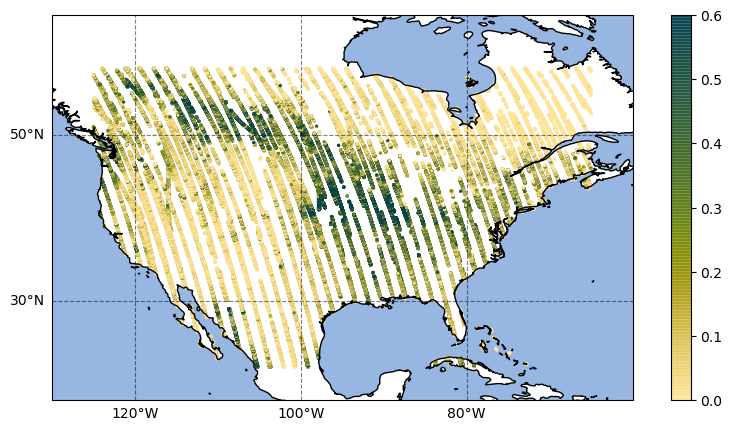

In [15]:
plot.plot_df(df_sif, "sif_residuals", vmin=0, vmax=0.6);

In [17]:
df_sif.to_csv("l2_sif_residuals_north_america.csv")